In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression

# Helper Functions

In [2]:
def to_list(elements) -> list:
    '''
    Return a list of elements that where separated by ";"

    :param elements: the (potencial) elements to convert to a list, can be (str) or (np.nan)
    :returns: (list[str]) list of elements with 0 or more elements
    
    Example:
    >>> import numpy as np; to_list(np.nan)
    []
    
    >>> to_list("c++;c#")
    ["c++", "c#"]
    '''

    if type(elements) != str: # assuming nan
        return []
    else:
        return elements.split(";")

In [3]:
def df_to_features(df: pd.DataFrame, column: str) -> list:
    '''
    Explode a column of a pd.DataFrame containing several features
    
    :param df: (pd.DataFrame) DataFrame that have the column to explode
    :param column: (str) The name of the column with the values to explode
    
    :returns: (list[dict]) A list of dicts that have a true value for a particular line
    
    Example:
    >>> df_to_features(pd.DataFrame([{'a': 'b;c'}]), 'a')
    [{'b': 1, 'c': 1}]
    '''
    
    records = []
    for index, row in df.iterrows():
        line = {}
        elements = to_list(row[column])
        if len(elements)>0:
            for e in elements:
                line[e] = 1
                    
        records.append(line)
        
    return records

In [4]:
def df_positive_columns(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Return a dataframe with the number of positive examples (1"s) for each column

    :param df: (pd.DataFrame)  The DataFrame to analyse 
    :returns: (pd.DataFrame) The number of positives per column
    
    Example:
    >>> df_positive_columns(pd.DataFrame([{'a': 0, 'b': 1}, {'a': 1, 'b': 0}]))
    pd.DataFrame([{'a': 1, 'b': 1}])
    '''
    
    result = {}
    cols = df.columns
    for index, row in df.iterrows():
        for c in cols:
            if c in result:
                result[c] = result[c] + row[c]
            else:
                result[c] = row[c]
    
    return pd.DataFrame([result])

In [5]:
def df_to_binary_labels(df):
    '''
    Convert a dataframe with the column "Very satisfied" to a binary form.
    
    :param df: (pd.DataFrame) The DataFrame that have the data to be converted to binary labels
    :returns: (list[int]) 0/1 represantation of the column
    
    Example:
    >>> df_to_binary_labels(pd.DataFrame([{'Very satisfied': 1}, {'Very satisfied': 0}]))
    [{'label': 1}, {'label': 0}]
    '''

    records = []
    for index, row in df.iterrows():
        records.append({"label": row['Very satisfied']})
        
    return records

In [6]:
def df_to_float_labels(df):
    '''
     Convert a dataframe with the columns to a float form for a regression model.
     
     :param df: (pd.DataFrame) The DataFrame that have the data to be converted to floating labels.
     :returns: (list[int]) -2 to 2, inclusive, in 1 steps represantation of the column.
     
     Example:
     >>> df_to_float_labels(  \
        pd.DataFrame( \
            [  \
                {'Very satisfied': 1},  \
                {'Slightly satisfied': 1},  \
                {'Neither satisfied nor dissatisfied': 1},  \
                {'Slightly dissatisfied': 1},  \
                {'Very dissatisfied': 1} \
            ]  \
        )  \
    )
    
    [{'label': 2}, {'label': 1}, {'label': 0}, {'label': -1}, {'label': -2}]
    '''
    
    records = []
    for index, row in df.iterrows():
        if row['Very satisfied'] == 1:
            records.append({"label": 2})
        elif row['Slightly satisfied'] == 1:
            records.append({"label": 1})
        elif row['Neither satisfied nor dissatisfied'] == 1:
            records.append({"label": 0})
        elif row['Slightly dissatisfied'] == 1:
            records.append({"label": -1})
        else: # Very dissatisfied
            records.append({"label": -2})
        
    return records

In [7]:
def fit_classifier(X: pd.DataFrame, y: pd.DataFrame) -> dict:
    '''
    Train a DecisionTree Model for a binary classification
    
    :param X: (pd.DataFrame) The DataFrame with the features
    :param y: (pd.DataFrame) The DataFrame with the label
    :returns: (dict) r2_score and confusion (matrix)
    '''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    return {'r2_score': r2, 'confusion': confusion}
   

In [8]:
def fit_regression(X, y):
    '''
    Train a LinearRegression Model for a regression
    
    :param X: (pd.DataFrame) The DataFrame with the features
    :param y: (pd.DataFrame) The DataFrame with the label
    :returns: (dict) r2_score
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    classifier = LinearRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return {'r2_score': r2}


In [9]:
def df_extract_features(df: pd.DataFrame, column: str) -> pd.DataFrame:
    '''
    Extract features of a particular column and returns the filled pd.DataFrame back
    
    :param df: (pd.DataFrame) The DataFrame with the data to be extracted
    :param column: (str) The column with the data to extract
    :returns: pd.DataFrame with feature columns, filled missing values with 0 
    
    Example:
    >>> df_extract_features(pd.DataFrame([{'a': 'b;c'}, {'a': 'c'}]), 'a')
    pd.DataFrame([{'b': 1.0, 'c': 1}, {'b': 0.0, 'c': 1}])
    '''
    return pd.DataFrame(df_to_features(df, column)).fillna(0.)

In [10]:
def plot_features(df_positive_columns: pd.DataFrame):
    '''
    Plot features using seabron
    
    :param df_positive_columns: (pd.DataFrame) The DataFrame to plot
    :returns: plot
    '''

    plt = sns.boxplot(data=df_positive_columns)
    plt.set_xticklabels(labels=df_positive_columns.columns, rotation=45)

    return plt

# Settings

In [11]:
# set Figure size for seaborn plots
sns.set(rc={'figure.figsize':(11,8)})

# Data Reading

In [12]:
# set data path
data = os.path.join("developer_survey_2020", "survey_results_public.csv")

In [13]:
# read csv using pandas
df = pd.read_csv(data)

In [14]:
# total size
len(df)

64461

In [15]:
# we only care about data with job satisfaction, other rows are filtered out
df = df[~ df['JobSat'].isnull()]

In [16]:
# all job sat
len(df)

45194

# Information on Job Salutation

In [17]:
job_salutation_df = df_extract_features(df, 'JobSat')

In [18]:
job_salutation_count_df = df_positive_columns(job_salutation_df)
job_salutation_count_df.iloc[0].to_dict()

{'Slightly satisfied': 13930.0,
 'Very dissatisfied': 3746.0,
 'Slightly dissatisfied': 7124.0,
 'Very satisfied': 14611.0,
 'Neither satisfied nor dissatisfied': 5783.0}

<AxesSubplot:>

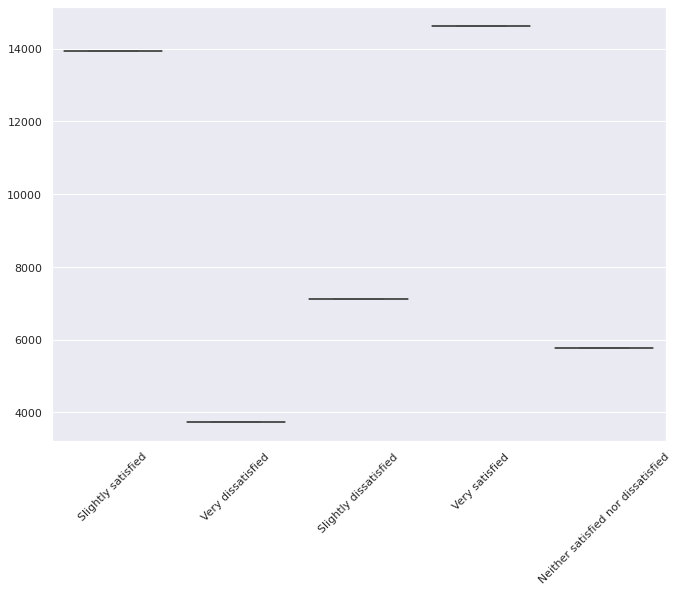

In [19]:
plot_features(job_salutation_count_df)

# Job Salutation -> Platform Relation

In [20]:
platform_features_df = df_extract_features(df, 'PlatformWorkedWith')

In [21]:
platform_features_count_df = df_positive_columns(platform_features_df)
platform_features_count_df.iloc[0].to_dict()

{'Windows': 20663.0,
 'iOS': 5139.0,
 'Android': 9605.0,
 'Docker': 16267.0,
 'WordPress': 5499.0,
 'Linux': 22655.0,
 'Raspberry Pi': 5666.0,
 'AWS': 12322.0,
 'Heroku': 4254.0,
 'MacOS': 10503.0,
 'Google Cloud Platform': 5845.0,
 'Kubernetes': 5405.0,
 'Arduino': 3361.0,
 'Slack Apps and Integrations': 3260.0,
 'Microsoft Azure': 6673.0,
 'IBM Cloud or Watson': 577.0}

<AxesSubplot:>

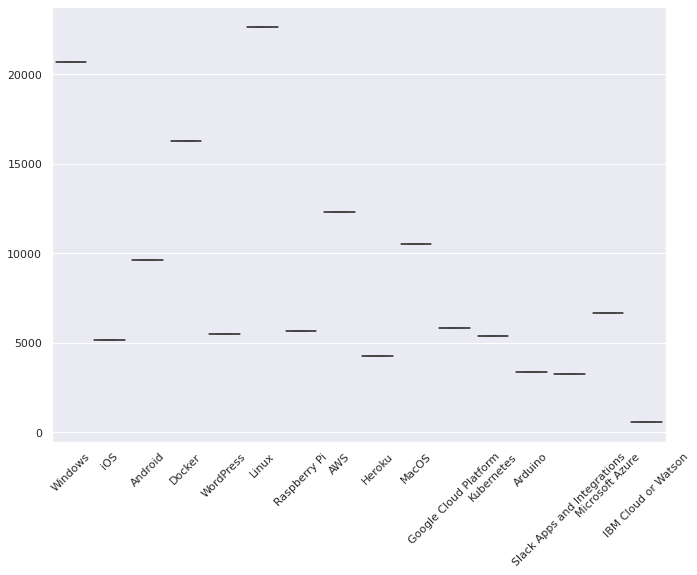

In [22]:
plot_features(platform_features_count_df)

<AxesSubplot:>

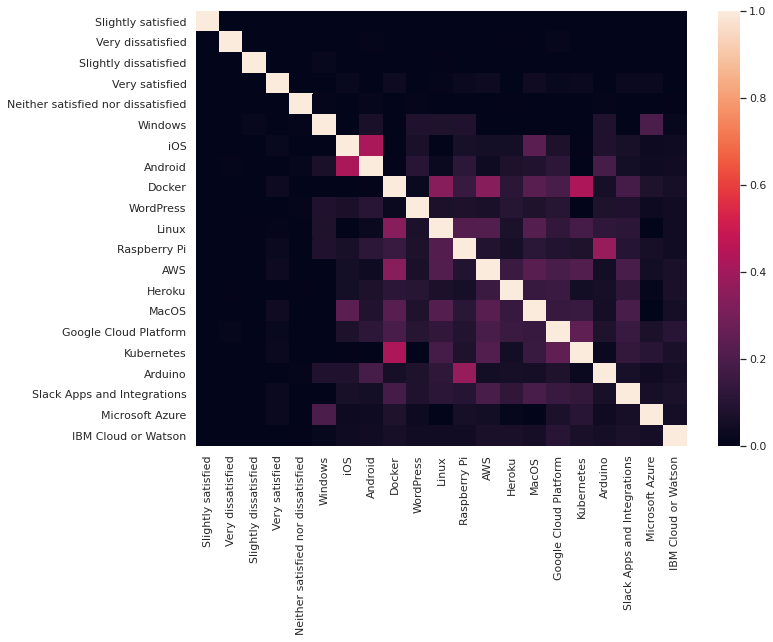

In [23]:
sns.heatmap(pd.concat([job_salutation_df, platform_features_df],axis=1, join='inner').corr(), vmin=0, vmax=1)

# Job Salutation -> Misc Tech Work

In [24]:
misc_tech_features_df = df_extract_features(df, 'MiscTechWorkedWith')

In [25]:
misc_tech_features_count_df = df_positive_columns(misc_tech_features_df)
misc_tech_features_count_df.iloc[0].to_dict()

{'.NET': 11270.0,
 '.NET Core': 8809.0,
 'React Native': 3608.0,
 'Ansible': 2595.0,
 'Pandas': 4458.0,
 'Node.js': 16068.0,
 'TensorFlow': 3043.0,
 'Torch/PyTorch': 1188.0,
 'Unity 3D': 2598.0,
 'Teraform': 2269.0,
 'Hadoop': 1445.0,
 'Flutter': 1969.0,
 'Cordova': 2000.0,
 'Keras': 1621.0,
 'Xamarin': 1842.0,
 'Unreal Engine': 714.0,
 'Apache Spark': 1650.0,
 'Puppet': 802.0,
 'Chef': 621.0}

<AxesSubplot:>

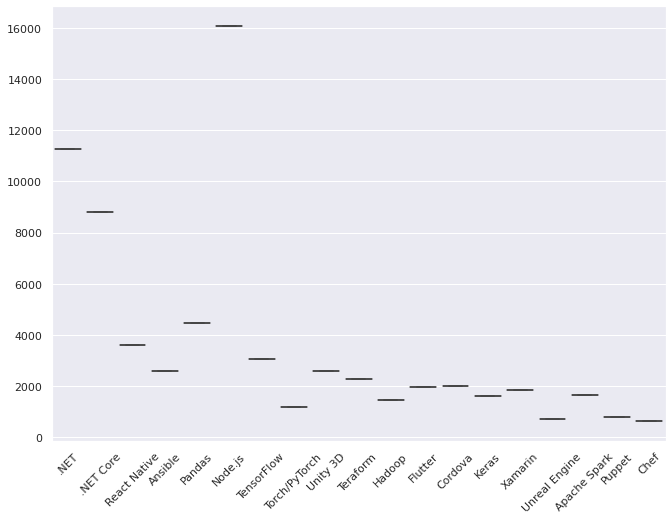

In [26]:
plot_features(misc_tech_features_count_df)

<AxesSubplot:>

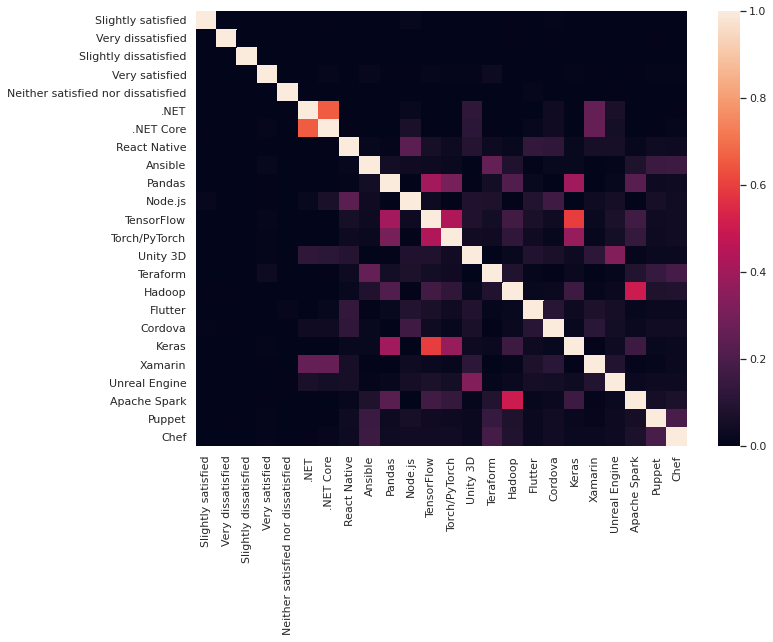

In [27]:
sns.heatmap(pd.concat([job_salutation_df, misc_tech_features_df],axis=1, join='inner').corr(), vmin=0, vmax=1)

# Job Salutation -> Language relation

In [28]:
language_features_df = df_extract_features(df, 'LanguageWorkedWith')

In [29]:
language_features_count_df = df_positive_columns(language_features_df)
language_features_count_df.iloc[0].to_dict()

{'C#': 13919.0,
 'HTML/CSS': 26487.0,
 'JavaScript': 29727.0,
 'Swift': 2565.0,
 'Java': 16086.0,
 'PHP': 10778.0,
 'Python': 17569.0,
 'SQL': 24363.0,
 'C': 7403.0,
 'TypeScript': 12232.0,
 'Bash/Shell/PowerShell': 15146.0,
 'Kotlin': 3379.0,
 'R': 2249.0,
 'VBA': 2614.0,
 'Perl': 1437.0,
 'C++': 8409.0,
 'Go': 4040.0,
 'Haskell': 728.0,
 'Ruby': 3240.0,
 'Rust': 2027.0,
 'Dart': 1506.0,
 'Scala': 1699.0,
 'Assembly': 1929.0,
 'Objective-C': 1891.0,
 'Julia': 328.0}

<AxesSubplot:>

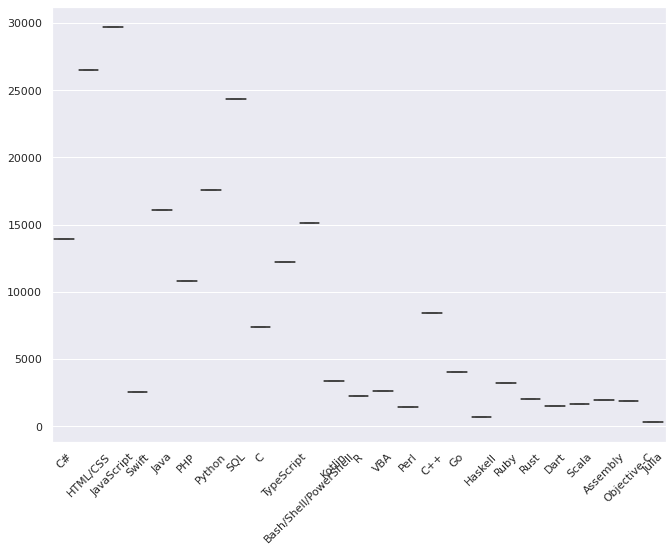

In [30]:
plot_features(language_features_count_df)

<AxesSubplot:>

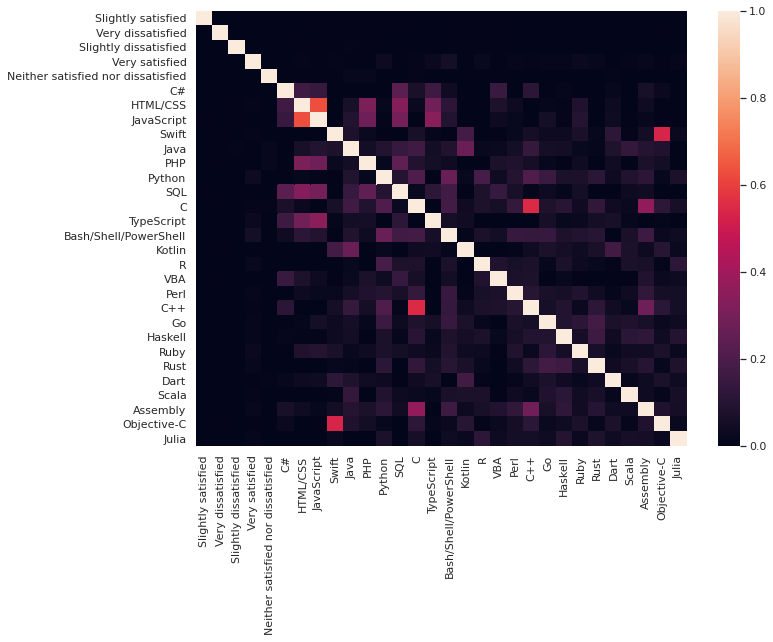

In [31]:
sns.heatmap(pd.concat([job_salutation_df, language_features_df],axis=1, join='inner').corr(), vmin=0, vmax=1)

# Merge Data together as binary classifier

In [32]:
binary_y = pd.DataFrame(df_to_binary_labels(job_salutation_df))

In [33]:
X = pd.concat([platform_features_df, misc_tech_features_df, language_features_df], axis=1, join='inner')

In [34]:
len(binary_y[binary_y['label'] == 1])

14611

In [35]:
len(binary_y[binary_y['label'] == 0])

30583

# Classification Model

In [36]:
classification_result = fit_classifier(X, binary_y)

In [37]:
classification_result['r2_score']

-0.9572668722130548

<AxesSubplot:>

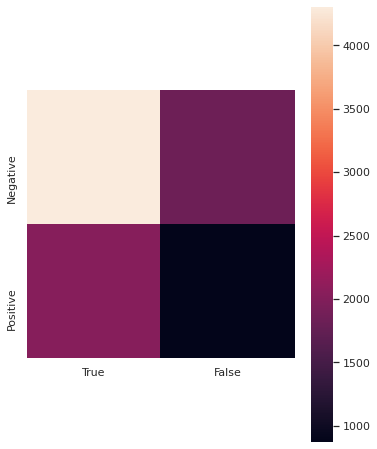

In [38]:
sns.set(rc={'figure.figsize':(6,8)})
sns.heatmap(
    data=classification_result['confusion'],
    square=True,
    xticklabels=['True', 'False'],
    yticklabels=['Negative','Positive']
)


# Regression Model

In [39]:
float_y = pd.DataFrame(df_to_float_labels(job_salutation_df))

<AxesSubplot:>

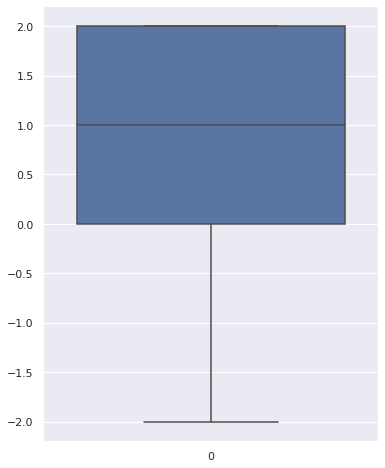

In [40]:
sns.boxplot(data=float_y['label'])

In [41]:
fit_regression(X, float_y)

{'r2_score': 0.006006631861843692}

# Header Image

<AxesSubplot:>

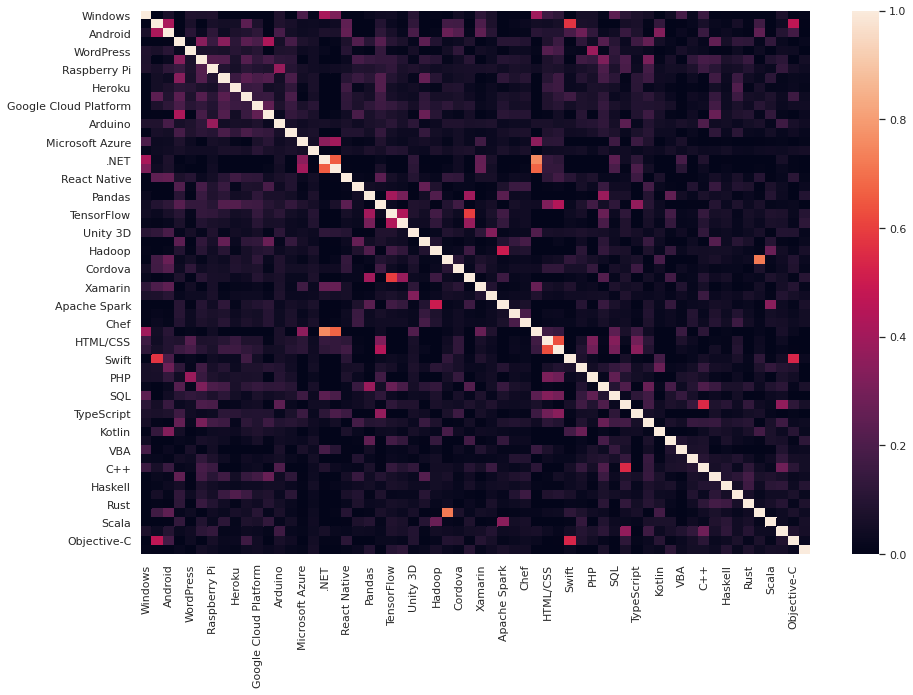

In [42]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(X.corr(), vmin=0, vmax=1)